In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generatePointCloud(N, covarianceMatrix, numPointsInCloud):

    customcolor = plt.cm.viridis(np.linspace(0, 1, 256))

    # rotation matrix
    rotationMatrix = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                              [np.sin(np.pi/4), np.cos(np.pi/4)]])
    inverseRotationMatrix = rotationMatrix.T

    # 1.
    S1 = (2*np.sqrt(3)*np.random.rand(N) - np.sqrt(3))
    S2 = np.random.randn(N)

    # 2.
    rotatedPoints = np.dot(rotationMatrix, np.column_stack((S1, S2)).T)
    X_rotated = rotatedPoints.T

    # 3.
    epsilon2 = 0.3
    densityThreshold = 2
    isIsolated = np.zeros(N)
    for i in range(N):
        distances = np.sqrt(np.sum((X_rotated - X_rotated[i])**2, axis=1))
        closePoints = np.sum(distances < epsilon2)
        isIsolated[i] = closePoints < densityThreshold

    X_filtered_rotated = X_rotated[isIsolated == 0]

    # 4.
    X_filtered = np.dot(inverseRotationMatrix, X_filtered_rotated.T).T

    M = X_filtered.shape[0]
    all_points = []
    point_clouds_before_rotation = []
    point_clouds = []

    plt.figure()
    pointCloudColors = np.array([[0.4, 0.4, 1],
                                 [1, 0.4, 0.4]]) # Light blue and light red

    for idx in range(M):
        mean = X_filtered[idx]
        P = np.random.multivariate_normal(mean, covarianceMatrix, numPointsInCloud)
        point_clouds_before_rotation.append(P)
        P_rotated = np.dot(P, rotationMatrix.T)
        point_clouds.append(P_rotated)
        all_points.extend(P_rotated)
        currentColor = pointCloudColors[idx % 2]
        plt.scatter(P_rotated[:, 0], P_rotated[:, 1], c=[currentColor], s=3, edgecolors='none')

    minY = min(X_filtered_rotated[:, 1])
    maxY = max(X_filtered_rotated[:, 1])
    relative_positions = np.round((X_filtered_rotated[:, 1] - minY) / (maxY - minY) * (len(customcolor) - 1)).astype(int)
    X_filtered_rotated_colors = customcolor[relative_positions]
    plt.scatter(X_filtered_rotated[:, 0], X_filtered_rotated[:, 1], c=X_filtered_rotated_colors, s=30, edgecolors='black')

    plt.axis('equal')
    plt.show()

    return point_clouds, all_points, X_filtered_rotated, X_filtered, point_clouds_before_rotation




In [5]:
pip install POT


Note: you may need to restart the kernel to use updated packages.


In [6]:
import ot

def sinkhorn_w2_distance(u_samples, v_samples, reg, numItermax):
    # pairwise distance
    M = ot.dist(u_samples, v_samples, metric='sqeuclidean')
    # Normalize
    M_normalized = M / M.max()
    # Sinkhorn
    P = ot.bregman.sinkhorn_stabilized(a=np.ones(u_samples.shape[0])/u_samples.shape[0],
                                       b=np.ones(v_samples.shape[0])/v_samples.shape[0],
                                       M=M_normalized, reg=reg,
                                       numItermax=numItermax)
    distance = np.sum(P * M)
    return distance


In [7]:
import numpy as np
import ot

def wasserstein_distance(u_samples, v_samples):

    N = u_samples.shape[0]
    a = np.ones((N,)) / N
    b = np.ones((N,)) / N

    # Compute pairwise distance matrix
    M = ot.dist(u_samples, v_samples, metric='sqeuclidean')

    # Compute Wasserstein distance
    gamma = ot.emd(a, b, M)
    distance = np.sum(gamma * M)

    return distance


**bold text**

Example of using Sinkhorn and Linear Programming when Computing the W2 distance:

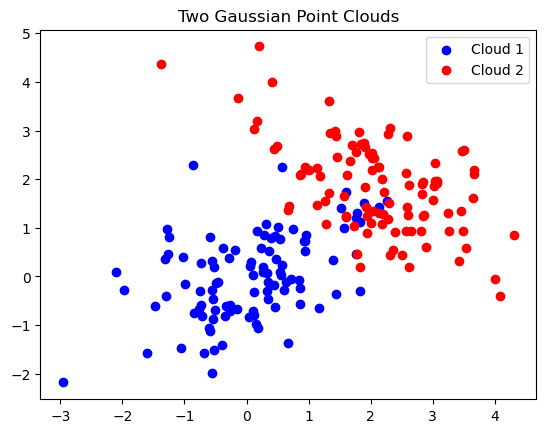

In [8]:
import numpy as np
import matplotlib.pyplot as plt

mean1 = [0, 0]
cov1 = [[1, 0.5], [0.5, 1]]
points1 = np.random.multivariate_normal(mean1, cov1, 100)

mean2 = [2, 2]
cov2 = [[1, -0.5], [-0.5, 1]]
points2 = np.random.multivariate_normal(mean2, cov2, 100)

plt.scatter(points1[:, 0], points1[:, 1], c='blue', label='Cloud 1')
plt.scatter(points2[:, 0], points2[:, 1], c='red', label='Cloud 2')
plt.legend()
plt.title("Two Gaussian Point Clouds")
plt.show()


In [ ]:
sinkhorn_distance = sinkhorn_w2_distance(points1, points2, reg=0.005, numItermax=2000)

In [ ]:
emd_distance = wasserstein_distance(points1, points2)

In [9]:
 import numpy as np

def ICA(point_clouds, X_filtered, method):
    M = X_filtered.shape[0]
    epsilon = 0.2

    # Construct W
    W = np.zeros((M, M))
    for i in range(M):
        W[i, i] = 1
        for j in range(i+1, M):
            u_samples = point_clouds[i]
            v_samples = point_clouds[j]

            if u_samples.shape[0] != v_samples.shape[0]:
                print(f'Sizes mismatch at i={i}, j={j}')
                continue

            if method == 'sinkhorn':
                distance = sinkhorn_w2_distance(u_samples, v_samples, 0.2, 300)
            elif method == 'linear_programming':
                distance = wasserstein_distance(u_samples, v_samples)

            value = np.exp(-distance/(2*epsilon))
            W[i, j] = value
            W[j, i] = value  # symmetry

    D = np.diag(W.sum(axis=1))
    D_inv = np.diag(1. / np.diag(D))
    L = np.dot(D_inv, W) - np.eye(M)
    scaled_L = (2/epsilon) * L
    eigValues, eigVectors = np.linalg.eig(scaled_L)

    phi_2 = eigVectors[:, 1]
    phi_3 = eigVectors[:, 2]

    Z = (1/M) * np.sum(np.tile(phi_2[:, np.newaxis], (1, 2)) * X_filtered, axis=0)
    if Z[0] < 0:
        phi_2 = -phi_2
        Z = (1/M) * np.sum(np.tile(phi_2[:, np.newaxis], (1, 2)) * X_filtered, axis=0)

    Z2 = (1/M) * np.sum(np.tile(phi_3[:, np.newaxis], (1, 2)) * X_filtered, axis=0)
    if Z2[1] < 0:
        phi_3 = -phi_3
        Z2 = (1/M) * np.sum(np.tile(phi_3[:, np.newaxis], (1, 2)) * X_filtered, axis=0)

    rotationmatrixapprox = Z / np.linalg.norm(Z)
    rotationmatrixapprox2 = Z2 / np.linalg.norm(Z2)

    A_tuta = np.array([rotationmatrixapprox, rotationmatrixapprox2]).T
    invA = np.linalg.inv(A_tuta)

    return invA, phi_2, phi_3, A_tuta




In [ ]:
%reset -f

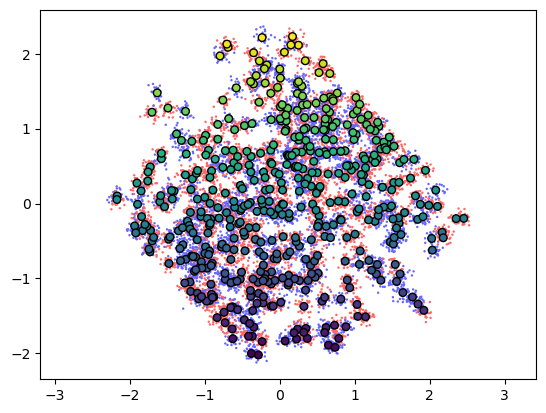

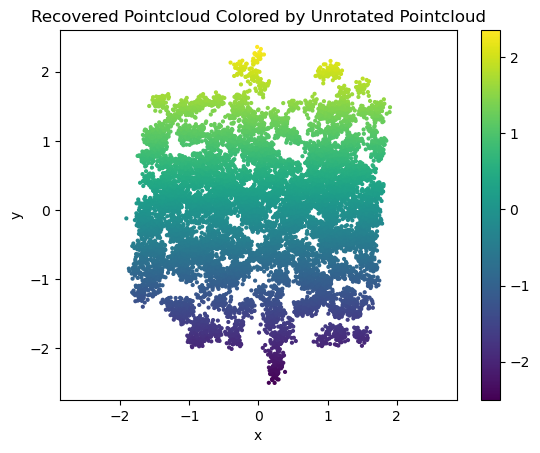

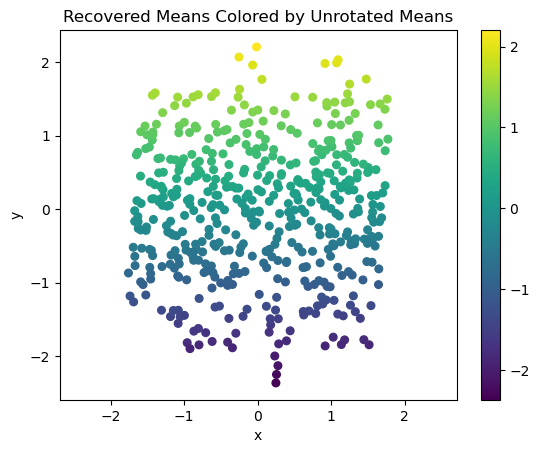

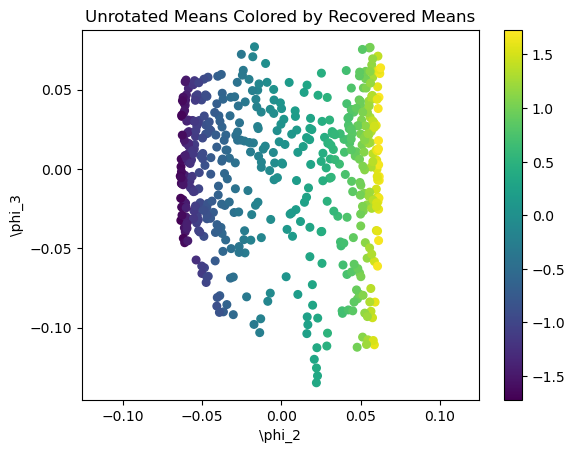

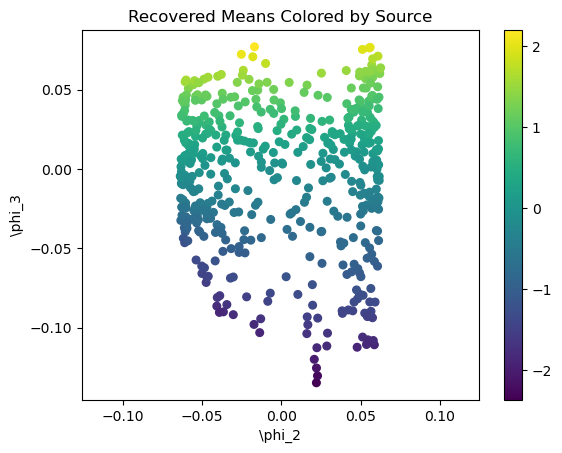

In [15]:

import numpy as np
import matplotlib.pyplot as plt



N = 500
covarianceMatrix = 0.003 * np.eye(2)
numPointsInCloud = 30

# Generate point clouds and means
point_clouds, all_points, X_filtered_rotated, X_filtered, point_clouds_before_rotation = generatePointCloud(N, covarianceMatrix, numPointsInCloud)
invA, phi_2, phi_3, A_tuta = ICA(point_clouds, X_filtered_rotated, 'linear_programming')


all_points_array = np.array(all_points)
transformed_points = (invA @ all_points_array.T).T
point_clouds_matrix = np.vstack(point_clouds_before_rotation)  # Assuming point_clouds_before_rotation is a list of arrays

plt.figure()
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c=point_clouds_matrix[:, 1], s=4)
plt.title('Recovered Pointcloud Colored by Unrotated Pointcloud')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar()
plt.show()


# Recovered mean:
recovered_means = (invA @ X_filtered_rotated.T).T
plt.figure()
plt.scatter(recovered_means[:, 0], recovered_means[:, 1], c=X_filtered[:, 1], s=30)
plt.title('Recovered Means Colored by Unrotated Means')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar()
plt.show()

# Plot
plt.figure()
plt.scatter(phi_2, phi_3, c=X_filtered[:, 0], s=30)
plt.title('Unrotated Means Colored by Recovered Means')
plt.xlabel('\phi_2')
plt.ylabel('\phi_3')
plt.axis('equal')
plt.colorbar()
plt.show()

# Plot eigenvectors
plt.figure()
plt.scatter(phi_2, phi_3, c=X_filtered[:, 1], s=30)
plt.title('Recovered Means Colored by Source')
plt.xlabel('\phi_2')
plt.ylabel('\phi_3')
plt.axis('equal')
plt.colorbar()
plt.show()


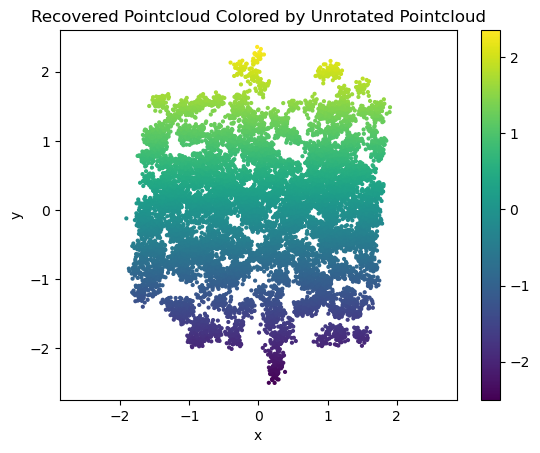

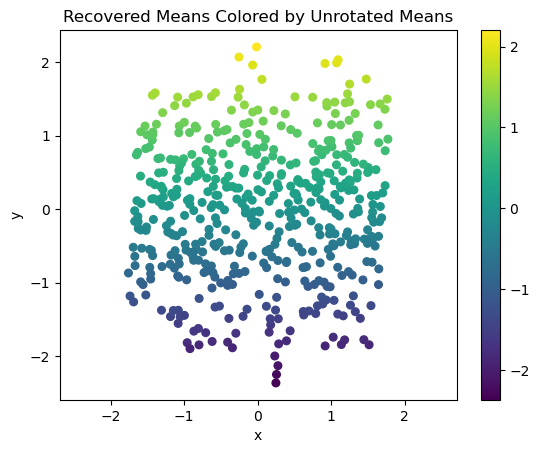

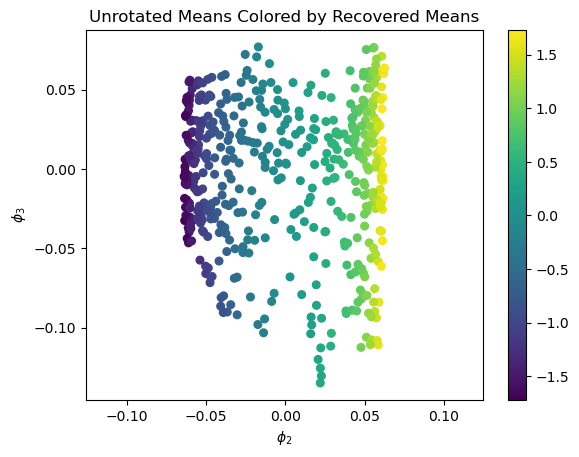

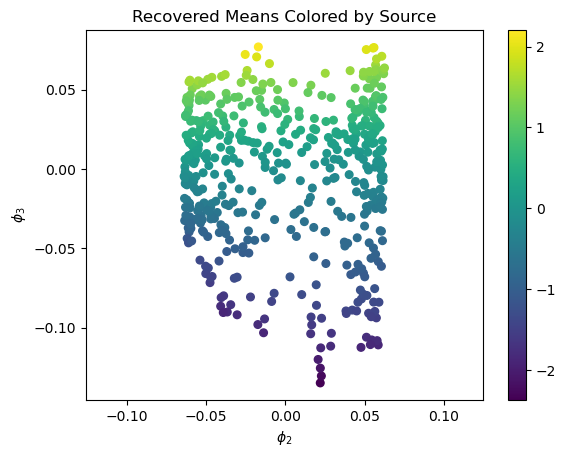

In [19]:
plt.figure()
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c=point_clouds_matrix[:, 1], s=4)
plt.title('Recovered Pointcloud Colored by Unrotated Pointcloud')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar()
plt.show()


# Recovered mean:
recovered_means = (invA @ X_filtered_rotated.T).T
plt.figure()
plt.scatter(recovered_means[:, 0], recovered_means[:, 1], c=X_filtered[:, 1], s=30)
plt.title('Recovered Means Colored by Unrotated Means')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.colorbar()
plt.show()

# Plot
plt.figure()
plt.scatter(phi_2, phi_3, c=X_filtered[:, 0], s=30)
plt.title('Unrotated Means Colored by Recovered Means')
plt.xlabel('$\phi_2$')
plt.ylabel('$\phi_3$')
plt.axis('equal')
plt.colorbar()
plt.show()

# Plot eigenvectors
plt.figure()
plt.scatter(phi_2, phi_3, c=X_filtered[:, 1], s=30)
plt.title('Recovered Means Colored by Source')
plt.xlabel('$\phi_2$')
plt.ylabel('$\phi_3$')
plt.axis('equal')
plt.colorbar()
plt.show()